## Predicting Stock Price Movements 

#### import all needed libraries for this project

In [1]:
import pandas as pd
import numpy as np
from data_processing import Training_Data
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import IPython
import IPython.display
from ta import add_all_ta_features
from ta.utils import dropna
from pykalman import KalmanFilter
import yfinance as yf

##### Using the yfinance historical data api to fetch stock price data in a given timeframe

In [2]:
data = yf.download("SPY", start="1900-01-01", end="2022-10-05")

[*********************100%***********************]  1 of 1 completed


#### view dataframe from API response

In [3]:
df=data.reset_index()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7470,2022-09-28,364.380005,372.299988,362.600006,370.529999,370.529999,110802200
7471,2022-09-29,366.809998,367.109985,359.700012,362.790009,362.790009,112952300
7472,2022-09-30,361.799988,365.910004,357.040009,357.179993,357.179993,153396100
7473,2022-10-03,361.079987,368.549988,359.209991,366.609985,366.609985,89756500
7474,2022-10-04,372.399994,378.000000,366.570007,377.970001,377.970001,103602800


#### figure 1:  SPY stock price since 2015-12-01

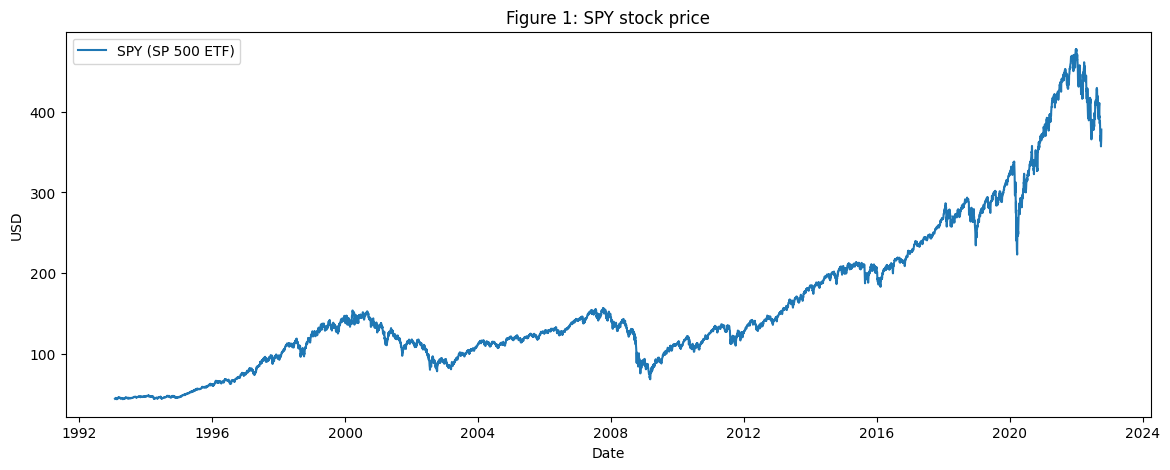

In [4]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(df['Date'], df['Close'], label='SPY (SP 500 ETF)')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 1: SPY stock price')
plt.legend()
plt.show()

#### encode the timestamp with sin and cos to capture periodicity of the timeseries

In [5]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

#### apply to both month and day

In [6]:
df['month'] = df.Date.dt.month
df = encode(df, 'month', 12)

df['day'] = df.Date.dt.day
df = encode(df, 'day', 31)

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,month,month_sin,month_cos,day,day_sin,day_cos
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.334032,1003200,1,0.500000,0.866025,29,-0.394356,0.918958
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.514219,480500,2,0.866025,0.500000,1,0.201299,0.979530
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.568268,201300,2,0.866025,0.500000,2,0.394356,0.918958
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,25.838549,529400,2,0.866025,0.500000,3,0.571268,0.820763
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,25.946665,531500,2,0.866025,0.500000,4,0.724793,0.688967


In [8]:
df = df.drop(columns=['month', 'day', 'Date', 'Adj Close'])

In [9]:
df.head()

,Open,High,Low,Close,Volume,month_sin,month_cos,day_sin,day_cos
0,43.96875,43.96875,43.75000,43.93750,1003200,0.500000,0.866025,-0.394356,0.918958
1,43.96875,44.25000,43.96875,44.25000,480500,0.866025,0.500000,0.201299,0.979530
2,44.21875,44.37500,44.12500,44.34375,201300,0.866025,0.500000,0.394356,0.918958
3,44.40625,44.84375,44.37500,44.81250,529400,0.866025,0.500000,0.571268,0.820763
4,44.96875,45.09375,44.46875,45.00000,531500,0.866025,0.500000,0.724793,0.688967


#### For now, we add all technical indicators available in the ta library for exploration purposes. The less descriptive TI's will be discarded. 

In [10]:
# Clean NaN values
df = dropna(df)

# Add all ta features
df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume")

/usr/local/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [11]:
df.tail()

,Open,High,Low,Close,Volume,month_sin,month_cos,day_sin,day_cos,volume_adi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
7470,364.380005,372.299988,362.600006,370.529999,110802200,-1.000000,-1.836970e-16,-0.571268,0.820763,3.959303e+10,...,-2.628146,-1.958851,-0.669296,10.144449,8.508256,1.636194,375.294897,1.967635,1.948528,743.311519
7471,366.809998,367.109985,359.700012,362.790009,112952300,-1.000000,-1.836970e-16,-0.394356,0.918958,3.957428e+10,...,-2.760455,-2.119172,-0.641283,10.571366,8.920878,1.650488,373.191039,-2.088897,-2.111023,725.695610
7472,361.799988,365.910004,357.040009,357.179993,153396100,-1.000000,-1.836970e-16,-0.201299,0.979530,3.942573e+10,...,-2.954968,-2.286331,-0.668637,13.802950,9.897292,3.905658,370.424106,-1.546353,-1.558434,712.927437
7473,361.079987,368.549988,359.209991,366.609985,89756500,-0.866025,5.000000e-01,0.571268,0.820763,3.947820e+10,...,-2.875481,-2.404161,-0.471320,11.286312,10.175096,1.111216,370.070963,2.640123,2.605874,734.389725
7474,372.399994,378.000000,366.570007,377.970001,103602800,-0.866025,5.000000e-01,0.724793,0.688967,3.958126e+10,...,-2.538309,-2.430991,-0.107319,10.237132,10.187503,0.049629,370.192328,3.098665,3.051626,760.244668


In [12]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'volume_adi', 'volume_obv', 'volume_cmf',
       'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap',
       'volume_mfi', 'volume_nvi', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_di

#### in addition, we will also add kalman filter as a feature and eventually FinBERT (although sentiment is more difficult to attain, but we have done it before)

In [16]:
# Construct a Kalman filter
kf = KalmanFilter(transition_matrices = [1],    # The value for At. It is a random walk so is set to 1.0
                  observation_matrices = [1],   # The value for Ht.
                  initial_state_mean = 0,       # Any initial value. It will converge to the true state value.
                  initial_state_covariance = 1, # Sigma value for the Qt in Equation (1) the Gaussian distribution
                  observation_covariance=1,     # Sigma value for the Rt in Equation (2) the Gaussian distribution
                  transition_covariance=.01)    # A small turbulence in the random walk parameter 1.0
# Get the Kalman smoothing
state_means, _ = kf.filter(df['Close'].values)
state_means

array([[ 21.96875   ],
       [ 29.4942053 ],
       [ 33.32571035],
       ...,
       [380.34404629],
       [379.03759482],
       [378.93604006]])

In [17]:
df['KF_mean'] = np.array(state_means)
df.head()


,Open,High,Low,Close,Volume,month_sin,month_cos,day_sin,day_cos,volume_adi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,KF_mean
0,43.96875,43.96875,43.75000,43.93750,1003200,0.500000,0.866025,-0.394356,0.918958,7.165714e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,-72.559286,NaN,0.000000,21.968750
1,43.96875,44.25000,43.96875,44.25000,480500,0.866025,0.500000,0.201299,0.979530,1.197071e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0.711238,0.708720,0.711238,29.494205
2,44.21875,44.37500,44.12500,44.34375,201300,0.866025,0.500000,0.394356,0.918958,1.348046e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0.211864,0.211640,0.924609,33.325710
3,44.40625,44.84375,44.37500,44.81250,529400,0.866025,0.500000,0.571268,0.820763,1.806860e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,1.057082,1.051534,1.991465,35.753673
4,44.96875,45.09375,44.46875,45.00000,531500,0.866025,0.500000,0.724793,0.688967,2.178910e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,0.418410,0.417537,2.418208,37.429544


Text(0, 0.5, 'Price')

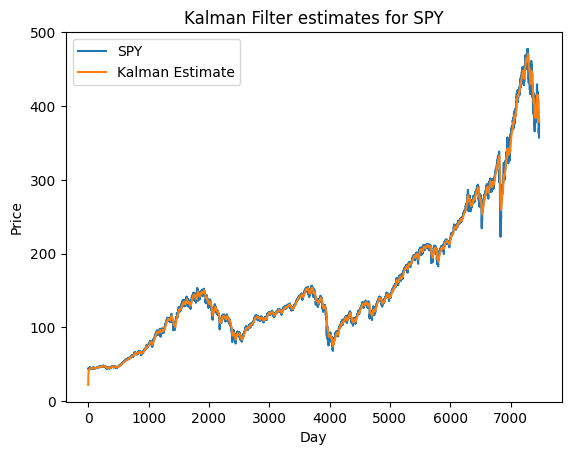

In [37]:
df[['Close','KF_mean']].plot()
plt.title('Kalman Filter estimates for SPY')
plt.legend(['SPY','Kalman Estimate'])
plt.xlabel('Day')
plt.ylabel('Price')


Text(0.5, 1.0, 'Time of day signal')

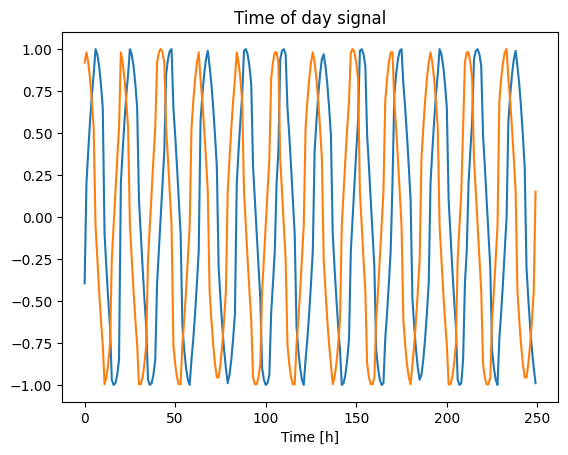

In [20]:
plt.plot(np.array(df['day_sin'])[:250])
plt.plot(np.array(df['day_cos'])[:250])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of month signal')

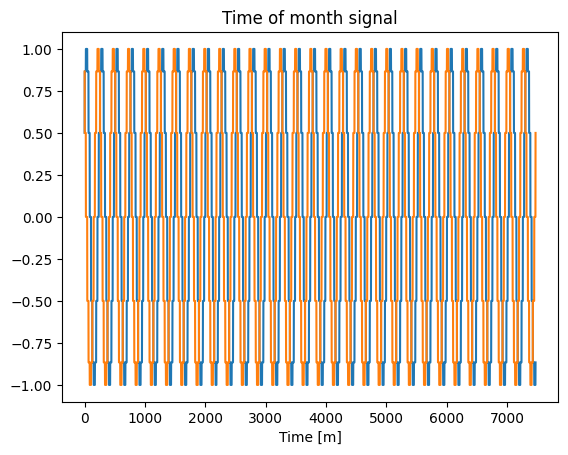

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.plot(np.array(df['month_sin']))
plt.plot(np.array(df['month_cos']))
plt.xlabel('Time [m]')
plt.title('Time of month signal')

In [21]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,7475.0,1.601185e+02,9.561306e+01,43.343750,1.031225e+02,1.299900e+02,2.032950e+02,4.792200e+02
High,7475.0,1.610790e+02,9.611764e+01,43.531250,1.040478e+02,1.308750e+02,2.042650e+02,4.799800e+02
Low,7475.0,1.590486e+02,9.504589e+01,42.812500,1.023206e+02,1.291900e+02,2.021550e+02,4.760600e+02
Close,7475.0,1.601179e+02,9.561929e+01,43.406250,1.033450e+02,1.300300e+02,2.032400e+02,4.777100e+02
Volume,7475.0,8.454145e+07,9.412803e+07,5200.000000,8.874250e+06,6.104010e+07,1.188418e+08,8.710263e+08
...,...,...,...,...,...,...,...,...
momentum_kama,7466.0,1.600464e+02,9.545650e+01,44.108330,1.029410e+02,1.301560e+02,2.031169e+02,4.703998e+02
others_dr,7475.0,2.619543e-02,1.457826e+00,-72.559286,-4.582743e-01,6.062122e-02,5.896384e-01,1.451977e+01
others_dlr,7474.0,2.879377e-02,1.192934e+00,-11.588654,-4.592541e-01,6.076124e-02,5.879371e-01,1.355773e+01
others_cr,7475.0,2.644220e+02,2.176257e+02,-1.209104,1.352091e+02,1.959431e+02,3.625662e+02,9.872489e+02


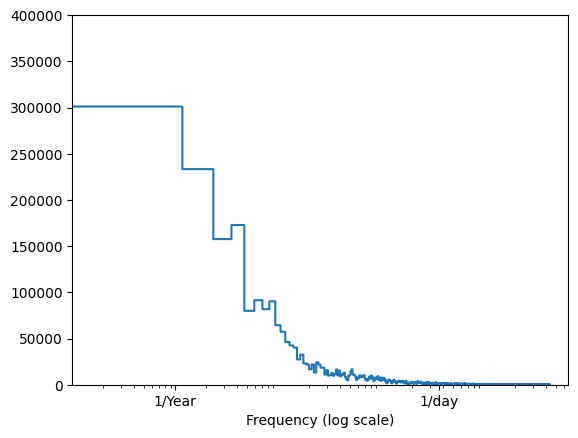

In [22]:
import tensorflow as tf
fft = tf.signal.rfft(df['Close'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Close'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [23]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

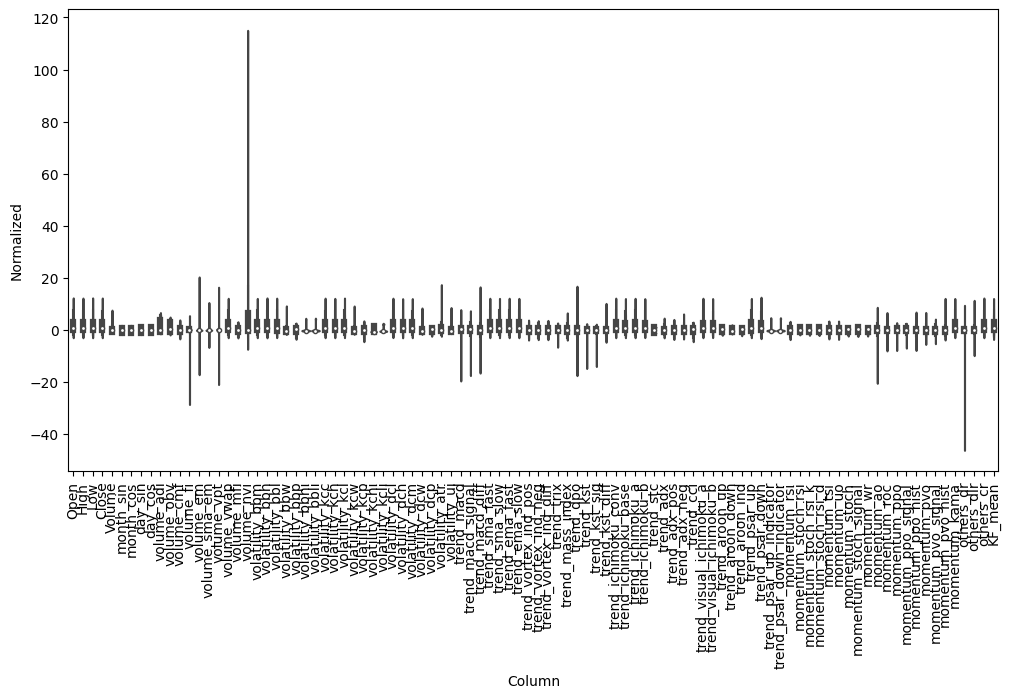

In [25]:
import seaborn as sns
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [26]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [27]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [28]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [29]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

KeyError: 'close'

In [94]:
w2.example = example_inputs, example_labels

In [95]:
def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

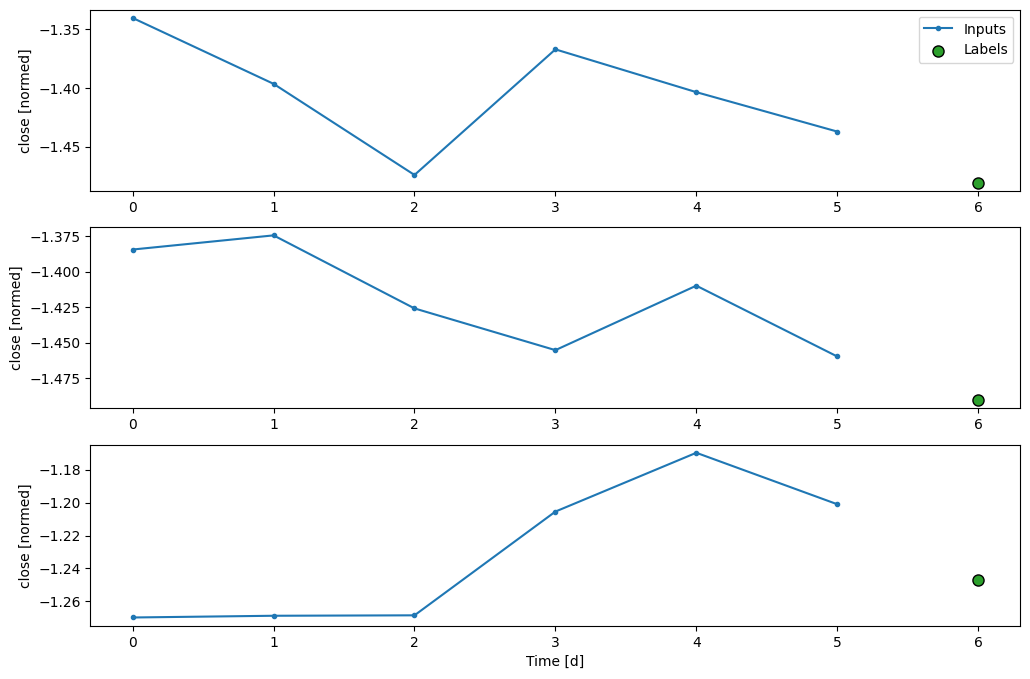

In [96]:
w2.plot()

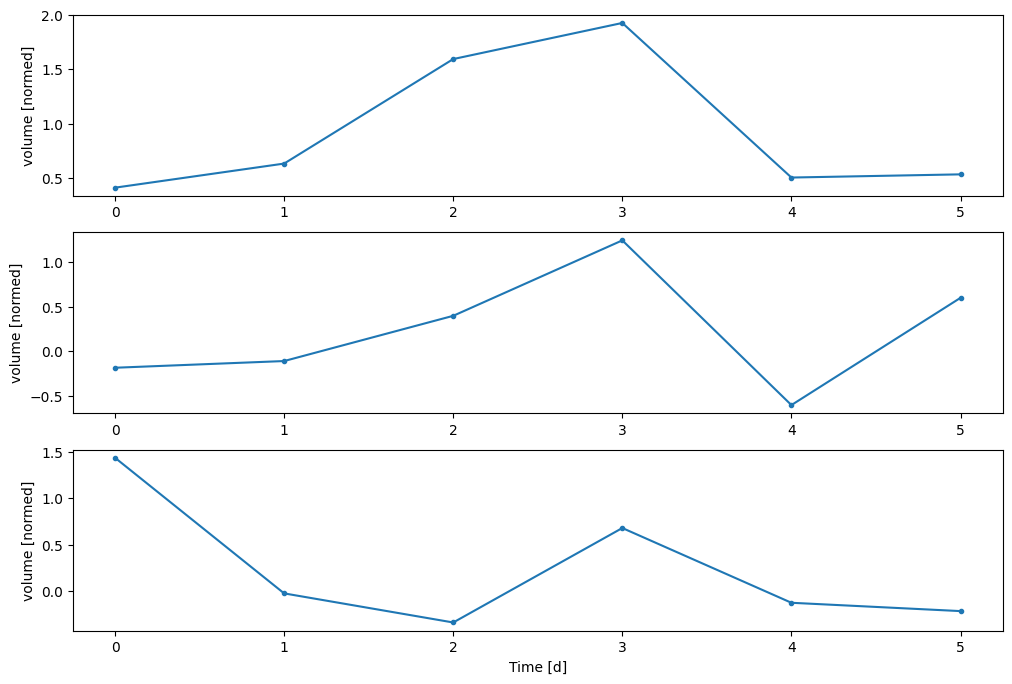

In [98]:
w2.plot(plot_col='volume')

In [100]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [101]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [102]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 11), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [103]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 11)
Labels shape (batch, time, features): (32, 1, 1)


In [104]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['close'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['close']

In [148]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [149]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 11)
Output shape: (32, 1, 1)


In [150]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [151]:
import IPython
import IPython.display
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

11/11 [==============================] - 0s 2ms/step - loss: 0.0372 - mean_absolute_error: 0.1526


In [152]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['close'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [120]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [121]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [122]:
baseline = Baseline(label_index=column_indices['close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

11/11 [==============================] - 0s 1ms/step - loss: 0.0089 - mean_absolute_error: 0.0725


In [123]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 11)
Output shape: (32, 24, 1)


In [124]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 11)
Output shape: (32, 1, 1)


In [125]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 11)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [153]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['close'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['close']

In [133]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 11)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


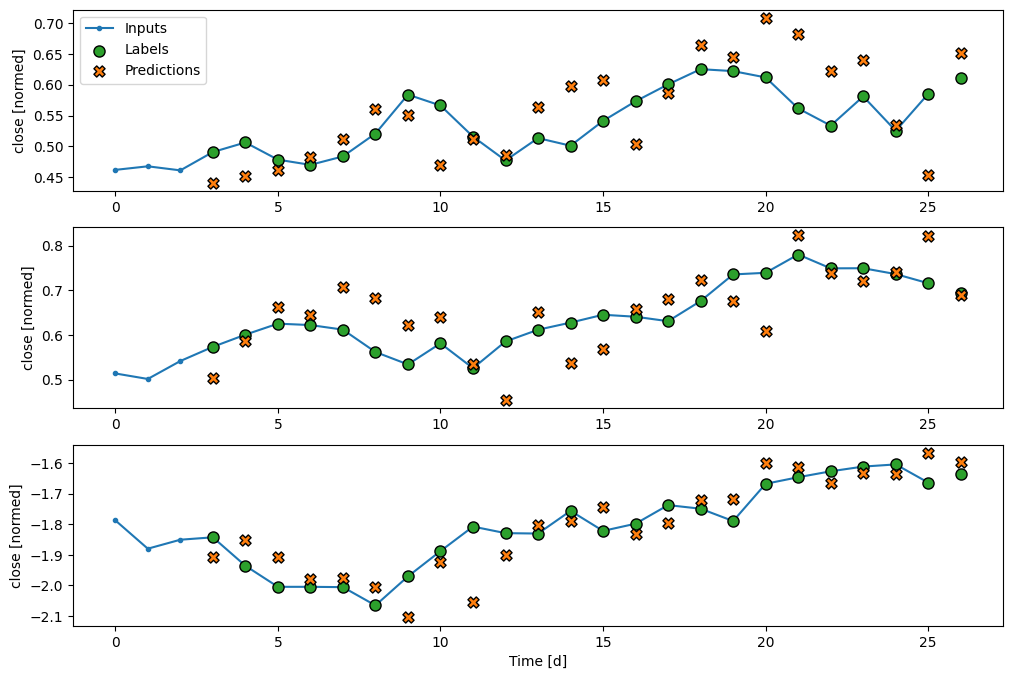

In [154]:
wide_conv_window.plot(conv_model)

In [144]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.LSTM(50, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [145]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 11)
Output shape: (32, 24, 1)


In [146]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

10/10 [==============================] - 0s 11ms/step - loss: 1.9932 - mean_absolute_error: 1.2309


2022-10-02 19:41:20.558950: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: Index out of range using input dim 2; input has only 2 dims


InvalidArgumentError: Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

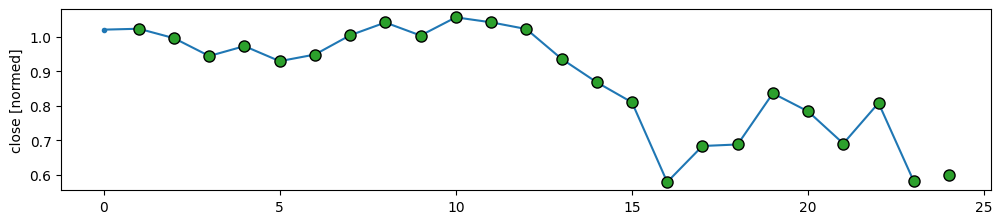

In [143]:
wide_window.plot(lstm_model)

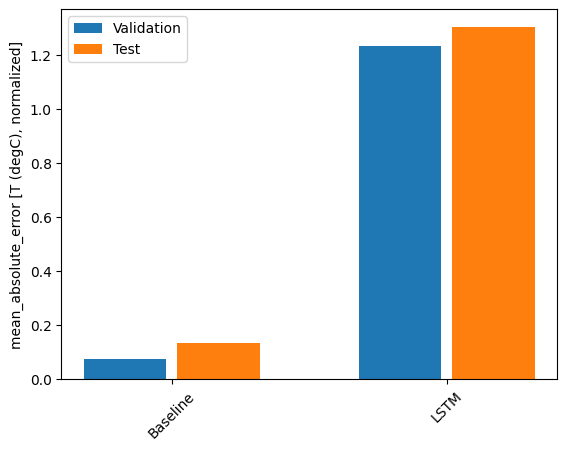

In [147]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()